# Baseline CNN Model for Speech Command Recognition

This notebook implements a baseline Convolutional Neural Network (CNN) for audio classification using the Speech Commands dataset, following the [TensorFlow Simple Audio Recognition Tutorial](https://www.tensorflow.org/tutorials/audio/simple_audio).

**Authors:** Nicholas Hefner, Arthur Ho, Hsuan-Yu Lin

## Overview
- Dataset: Google Speech Commands Dataset
- Model: CNN with spectrogram input
- Purpose: Establish baseline performance for comparison with traditional ML models using MFCC features


## 1. Setup and Imports


In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print(f"TensorFlow version: {tf.__version__}")


2025-12-02 16:38:47.345541: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-02 16:38:47.379778: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 16:38:48.624020: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0


## 2. Download and Explore the Dataset

We'll use a subset of the Speech Commands dataset containing 8 commands plus background noise.


In [6]:
# Path to the mini speech commands dataset
DATASET_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    # Download if not present
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data'
    )
    
print(f"Dataset location: {data_dir}")


Dataset location: data/mini_speech_commands_extracted/mini_speech_commands


In [7]:
# List the available commands
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']  # Remove README if present
print(f"Commands: {commands}")
print(f"Number of commands: {len(commands)}")


Commands: ['down' 'left' 'go' 'right' 'yes' 'no' 'stop' 'up']
Number of commands: 8


In [8]:
# Count files per command
for cmd in sorted(commands):
    cmd_path = data_dir / cmd
    if cmd_path.is_dir():
        num_files = len(list(cmd_path.glob('*.wav')))
        print(f"{cmd}: {num_files} files")


down: 1000 files
go: 1000 files
left: 1000 files
no: 1000 files
right: 1000 files
stop: 1000 files
up: 1000 files
yes: 1000 files


## 3. Create Training, Validation, and Test Datasets


In [9]:
# Audio parameters
BATCH_SIZE = 64
SAMPLE_RATE = 16000  # 16 kHz
AUDIO_LENGTH = 16000  # 1 second of audio

# Create training dataset (80% of data)
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    seed=SEED,
    output_sequence_length=AUDIO_LENGTH,
    subset='both'
)

# Get label names
label_names = np.array(train_ds.class_names)
print(f"Label names: {label_names}")


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


E0000 00:00:1764722570.761333    3754 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1764722570.768467    3754 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [10]:
# The audio is loaded as (batch, samples, channels)
# We need to squeeze to remove the channel dimension for mono audio
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [11]:
# Split validation set into validation and test sets
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

# Check the shapes
for example_audio, example_labels in train_ds.take(1):
    print(f"Audio shape: {example_audio.shape}")
    print(f"Labels shape: {example_labels.shape}")


Audio shape: (64, 16000)
Labels shape: (64,)


2025-12-02 16:42:51.091915: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 4. Visualize Audio Samples


2025-12-02 16:42:51.199462: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


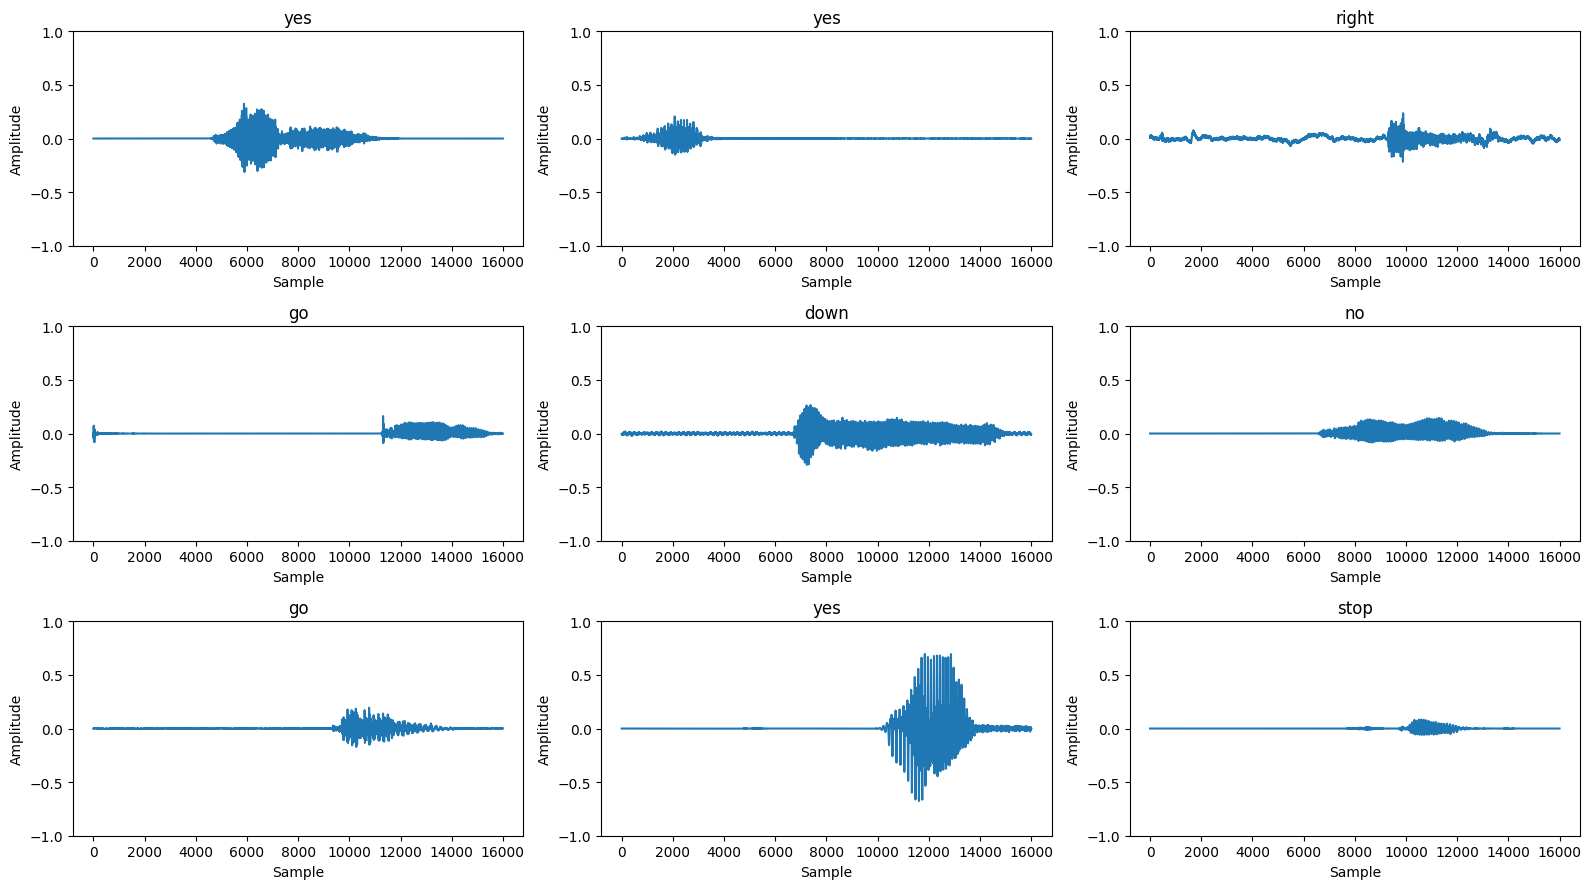

In [12]:
# Create figures directory
os.makedirs('figures', exist_ok=True)

# Plot some example waveforms
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i, (audio, label) in enumerate(train_ds.take(1)):
    for j in range(n):
        ax = axes[j // cols, j % cols]
        ax.plot(audio[j].numpy())
        ax.set_title(label_names[label[j]])
        ax.set_ylim([-1, 1])
        ax.set_xlabel('Sample')
        ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.savefig('figures/waveform_examples.png', dpi=150, bbox_inches='tight')
plt.show()


In [13]:
# Play an audio sample
for audio, label in train_ds.take(1):
    print(f"Playing: {label_names[label[0]]}")
    display.display(display.Audio(audio[0].numpy(), rate=SAMPLE_RATE))


Playing: stop


## 5. Convert Audio to Spectrograms

CNNs work well with image-like inputs. We convert audio waveforms to spectrograms, which represent frequency content over time.


In [14]:
def get_spectrogram(waveform):
    """
    Convert waveform to spectrogram using Short-Time Fourier Transform (STFT).
    
    Parameters:
    - waveform: Audio signal tensor
    
    Returns:
    - Spectrogram tensor
    """
    # Compute STFT
    spectrogram = tf.signal.stft(
        waveform, 
        frame_length=255,  # Window size
        frame_step=128     # Hop length
    )
    
    # Get magnitude (discard phase information)
    spectrogram = tf.abs(spectrogram)
    
    # Add channel dimension for Conv2D
    spectrogram = spectrogram[..., tf.newaxis]
    
    return spectrogram


In [15]:
# Test the spectrogram function
for i, (audio, label) in enumerate(train_ds.take(1)):
    example_audio = audio[0]
    example_label = label[0]
    
spectrogram = get_spectrogram(example_audio)
print(f"Waveform shape: {example_audio.shape}")
print(f"Spectrogram shape: {spectrogram.shape}")
print(f"Label: {label_names[example_label]}")


Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Label: stop


2025-12-02 16:42:52.543231: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


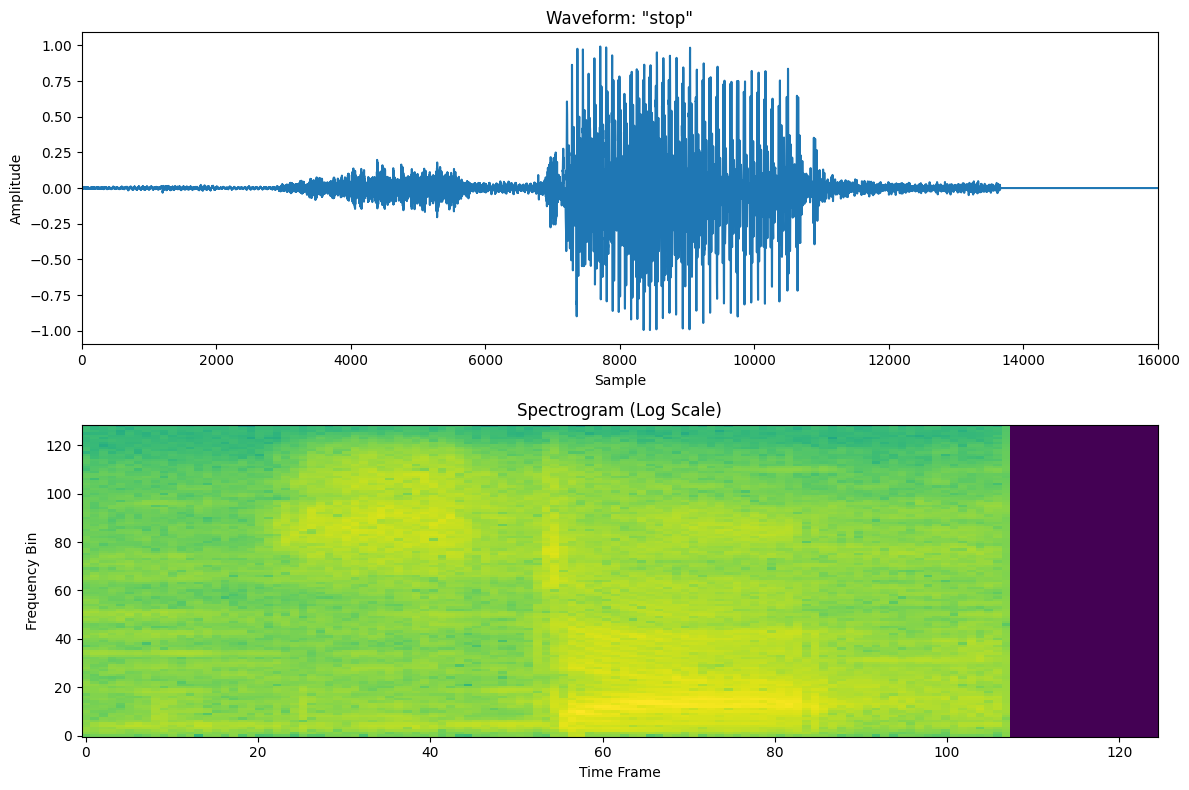

In [16]:
# Visualize the waveform and spectrogram
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot waveform
timescale = np.arange(example_audio.shape[0])
axes[0].plot(timescale, example_audio.numpy())
axes[0].set_title(f'Waveform: "{label_names[example_label]}"')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Amplitude')
axes[0].set_xlim([0, AUDIO_LENGTH])

# Plot spectrogram
log_spec = np.log(spectrogram.numpy()[:, :, 0].T + np.finfo(float).eps)
height = log_spec.shape[0]
width = log_spec.shape[1]
X = np.linspace(0, width, num=width)
Y = range(height)
axes[1].pcolormesh(X, Y, log_spec, shading='auto', cmap='viridis')
axes[1].set_title('Spectrogram (Log Scale)')
axes[1].set_xlabel('Time Frame')
axes[1].set_ylabel('Frequency Bin')

plt.tight_layout()
plt.savefig('figures/spectrogram_example.png', dpi=150, bbox_inches='tight')
plt.show()


In [17]:
# Create spectrogram dataset
def make_spec_ds(ds):
    """Convert audio dataset to spectrogram dataset."""
    return ds.map(
        lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)


In [18]:
# Check spectrogram dataset shapes
for example_spectrograms, example_labels in train_spectrogram_ds.take(1):
    print(f"Spectrogram batch shape: {example_spectrograms.shape}")
    print(f"Labels batch shape: {example_labels.shape}")
    break


Spectrogram batch shape: (64, 124, 129, 1)
Labels batch shape: (64,)


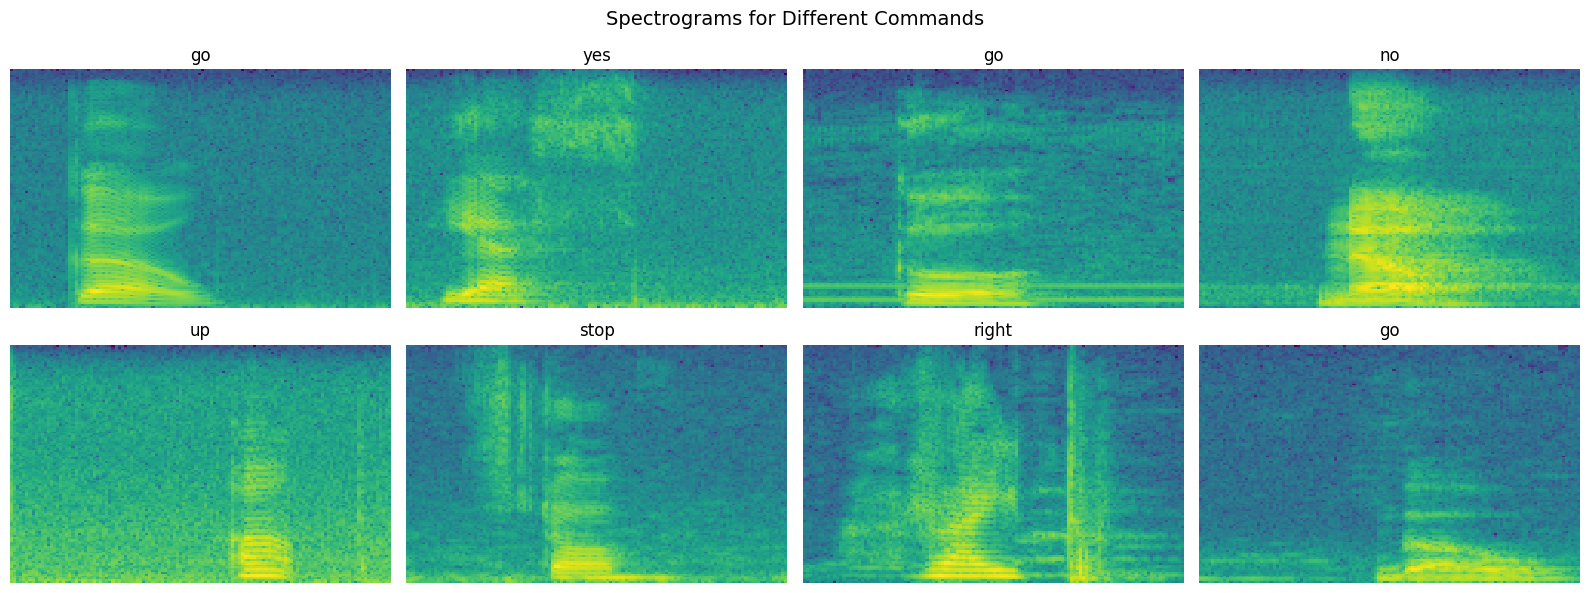

In [19]:
# Visualize spectrograms for each command
fig, axes = plt.subplots(2, 4, figsize=(16, 6))

for i, (spectrogram, label_id) in enumerate(train_spectrogram_ds.take(8)):
    ax = axes[i // 4, i % 4]
    log_spec = np.log(spectrogram[0].numpy()[:, :, 0].T + np.finfo(float).eps)
    ax.pcolormesh(log_spec, shading='auto', cmap='viridis')
    ax.set_title(label_names[label_id[0].numpy()])
    ax.axis('off')

plt.suptitle('Spectrograms for Different Commands', fontsize=14)
plt.tight_layout()
plt.savefig('figures/spectrograms_by_command.png', dpi=150, bbox_inches='tight')
plt.show()


## 6. Optimize Dataset Performance


In [20]:
# Cache and prefetch for better performance
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


## 7. Build the CNN Model

We build a simple CNN architecture for audio classification.


In [21]:
# Get input shape from dataset
for example_spectrograms, _ in train_spectrogram_ds.take(1):
    input_shape = example_spectrograms.shape[1:]
    
print(f"Input shape: {input_shape}")
num_labels = len(label_names)
print(f"Number of labels: {num_labels}")


Input shape: (124, 129, 1)
Number of labels: 8


In [22]:
# Normalization layer
norm_layer = layers.Normalization()

# Adapt normalization layer to training data
norm_layer.adapt(data=train_spectrogram_ds.map(lambda spec, label: spec))


In [23]:
# Build the CNN model
model = models.Sequential([
    layers.Input(shape=input_shape),
    
    # Normalize input
    norm_layer,
    
    # First convolutional block
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    # Flatten and classify
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 124, 129, 1)    │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 122, 127, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 238080)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    30,474,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,494,219 (116.33 MB)

 Trainable params: 30,494,216 (116.33 MB)

 Non-trainable params: 3 (16.00 B)

In [24]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


## 8. Train the Model


In [25]:
# Create models directory
os.makedirs('models', exist_ok=True)

# Training parameters
EPOCHS = 10

# Train the model
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 685ms/step - accuracy: 0.3864 - loss: 1.8316 - val_accuracy: 0.5430 - val_loss: 1.3041
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 694ms/step - accuracy: 0.6294 - loss: 1.0950 - val_accuracy: 0.6966 - val_loss: 0.9603
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 689ms/step - accuracy: 0.7444 - loss: 0.7793 - val_accuracy: 0.7695 - val_loss: 0.7474
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 674ms/step - accuracy: 0.8114 - loss: 0.5680 - val_accuracy: 0.7773 - val_loss: 0.6817
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 666ms/step - accuracy: 0.8586 - loss: 0.4327 - val_accuracy: 0.8008 - val_loss: 0.6357
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 68s 678ms/step - accuracy: 0.8848 - loss: 0.3521 - val_accuracy: 0.8008 - val_loss: 0.6713
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 660ms/step - accuracy: 0.9061 - loss: 0.2886 - val_accuracy: 0.8177 - val_loss: 0.6497
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 659ms/step - accuracy: 0.9198 - loss: 0

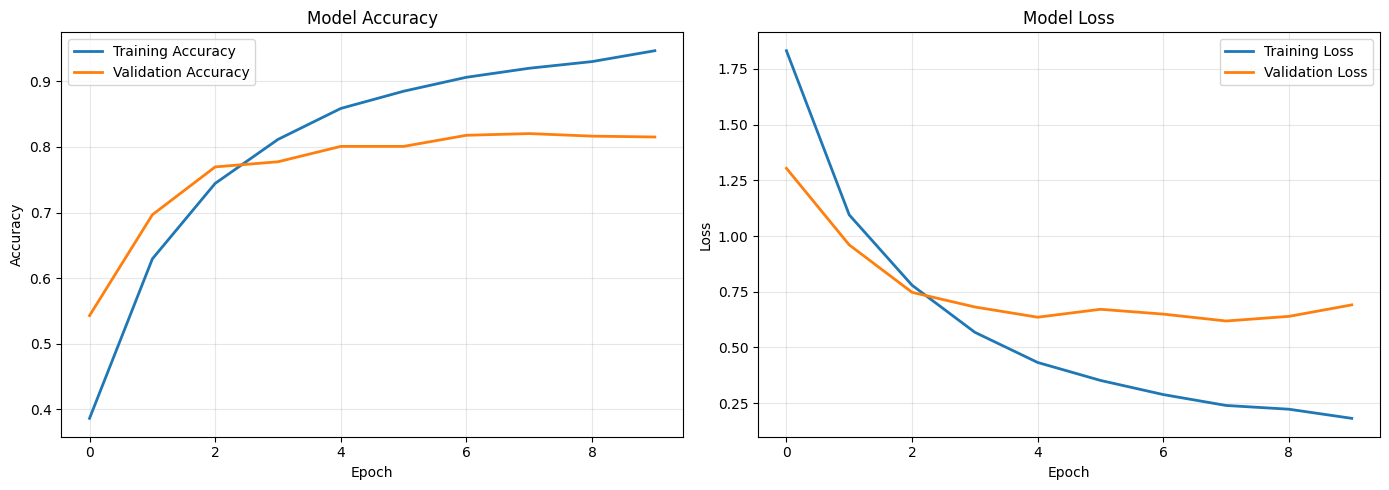

In [26]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/training_history.png', dpi=150, bbox_inches='tight')
plt.show()


## 9. Evaluate the Model


In [27]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_spectrogram_ds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.8161 - loss: 0.7394

Test Accuracy: 0.8161
Test Loss: 0.7394


In [28]:
# Generate predictions for confusion matrix
y_pred = []
y_true = []

for spectrograms, labels in test_spectrogram_ds:
    predictions = model.predict(spectrograms, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)


2025-12-02 16:54:16.909941: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


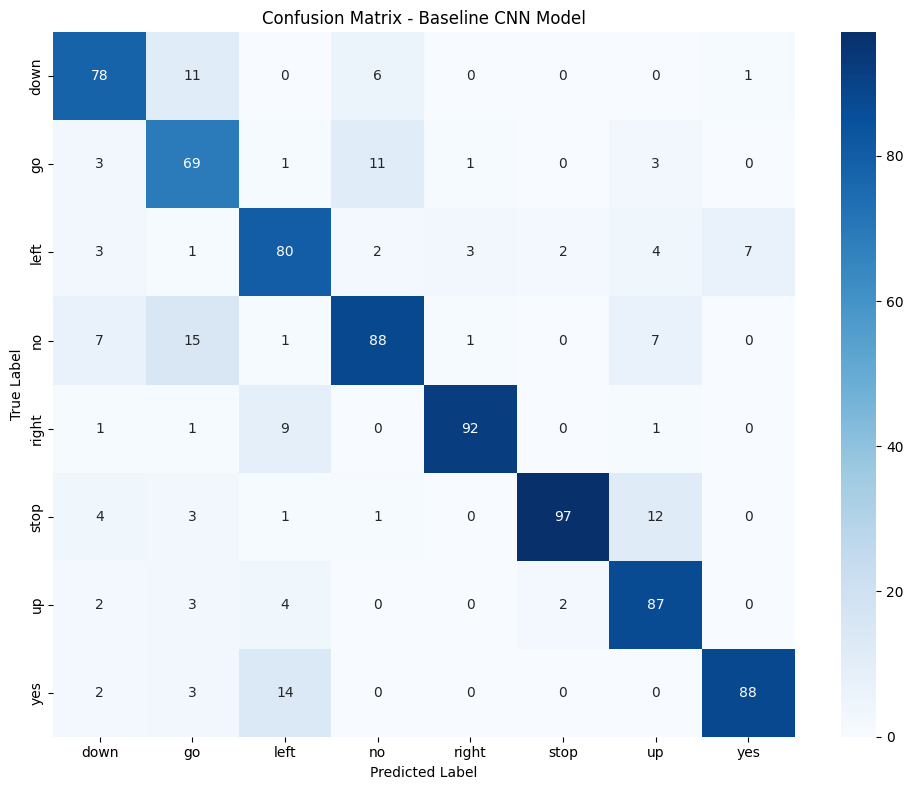

In [29]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Baseline CNN Model')
plt.tight_layout()
plt.savefig('figures/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


In [30]:
# Print classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=label_names))



Classification Report:
              precision    recall  f1-score   support

        down       0.78      0.81      0.80        96
          go       0.65      0.78      0.71        88
        left       0.73      0.78      0.75       102
          no       0.81      0.74      0.78       119
       right       0.95      0.88      0.92       104
        stop       0.96      0.82      0.89       118
          up       0.76      0.89      0.82        98
         yes       0.92      0.82      0.87       107

    accuracy                           0.82       832
   macro avg       0.82      0.82      0.82       832
weighted avg       0.83      0.82      0.82       832



## 10. Test with Individual Audio Files


In [31]:
# Function to predict a single audio file
def predict_audio_file(file_path):
    """
    Predict the command from an audio file.
    
    Parameters:
    - file_path: Path to the .wav file
    
    Returns:
    - Predicted command label
    """
    # Load and decode audio
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1, desired_samples=AUDIO_LENGTH)
    audio = tf.squeeze(audio, axis=-1)
    
    # Convert to spectrogram
    spectrogram = get_spectrogram(audio)
    spectrogram = spectrogram[tf.newaxis, ...]  # Add batch dimension
    
    # Predict
    predictions = model.predict(spectrogram, verbose=0)
    predicted_idx = np.argmax(predictions[0])
    predicted_label = label_names[predicted_idx]
    confidence = tf.nn.softmax(predictions[0])[predicted_idx].numpy()
    
    return predicted_label, confidence


In [32]:
# Test with a sample file
sample_file = str(data_dir / 'no/01bb6a2a_nohash_0.wav')
predicted_label, confidence = predict_audio_file(sample_file)
print(f"File: {sample_file}")
print(f"Predicted: {predicted_label} (confidence: {confidence:.2%})")

# Play the audio
audio_binary = tf.io.read_file(sample_file)
audio, _ = tf.audio.decode_wav(audio_binary)
display.display(display.Audio(audio.numpy().T, rate=SAMPLE_RATE))


File: data/mini_speech_commands_extracted/mini_speech_commands/no/01bb6a2a_nohash_0.wav
Predicted: no (confidence: 94.96%)


## 11. Save the Model


In [33]:
# Save the model
model.save('models/baseline_cnn_model.keras')
print("Model saved to 'models/baseline_cnn_model.keras'")


Model saved to 'models/baseline_cnn_model.keras'


In [34]:
# Save results summary
results = {
    'model_name': 'Baseline CNN',
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'num_epochs': len(history.history['loss']),
    'final_train_accuracy': history.history['accuracy'][-1],
    'final_val_accuracy': history.history['val_accuracy'][-1],
    'input_type': 'Spectrogram (STFT)',
    'num_parameters': model.count_params(),
}

print("\n" + "=" * 50)
print("BASELINE CNN MODEL RESULTS")
print("=" * 50)
for key, value in results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")



BASELINE CNN MODEL RESULTS
model_name: Baseline CNN
test_accuracy: 0.8161
test_loss: 0.7394
num_epochs: 10
final_train_accuracy: 0.9466
final_val_accuracy: 0.8151
input_type: Spectrogram (STFT)
num_parameters: 30494219


## 12. Summary and Next Steps

### Results Summary
This baseline CNN model uses spectrograms (computed via STFT) as input features. The model architecture consists of:
- 2 Convolutional layers (32 and 64 filters)
- MaxPooling and Dropout for regularization
- Dense layers for classification

### Next Steps
To compare with traditional ML approaches using MFCC features, we can:
1. Extract MFCC features from audio files using `librosa`
2. Train classical ML models (SVM, Random Forest, etc.)
3. Compare performance metrics

See the `traditional_ml_mfcc.ipynb` notebook for the traditional ML implementation.
